## Housing Market Analysis

As a real estate data analyst, the insights derived from this model can be very useful in various aspects of your business. 

### How This Model Helps

1. Price Prediction

- With an improved R^2 score and reduced error, you can predict property prices more accurately. This can be valuable for real estate agents, investors, and developers when determining asking prices, setting budgets, or making investment decisions.

2. Feature Importance

- Understanding which features (like square footage) have the biggest impact on price allows you to prioritize those in your business decisions. For example, you could focus on increasing square footage or targeting properties with larger homes for more lucrative investments.

3. Market Segmentation

- You can segment the market based on predicted price ranges. This can help target specific demographics or locations more effectively. For example, if you know that square footage plays a big role in price, you could focus on larger properties that cater to specific buyers (e.g., families or luxury buyers).

4. Investment Decisions

The insights from this model can guide your investment strategy. If you know that square footage and certain neighborhoods are strongly correlated with higher prices, you can focus your investments on those types of properties for higher returns.

5. Targeted Marketing

By understanding which factors influence price, you can tailor your marketing efforts. For example, if you know that properties in urban areas with a certain size or layout are in high demand, you can focus marketing efforts on those.

In [19]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [20]:
# Unzipping the file
with zipfile.ZipFile('Housing_price.zip', 'r') as zip_ref:
    zip_ref.extractall('Housing_price')

# Get list of all files in the extracted folder
file_list = os.listdir('Housing_price')

# Load the first CSV file into a DataFrame
csv_file = [file for file in file_list if file.endswith('.csv')][0]
df = pd.read_csv(f'Housing_price/{csv_file}')

# Display the first few rows to inspect the data
print(df.head())

#  Initial Data Exploration
# Check the basic information and data types of each column
print("\nData Types and Non-Null Counts:\n")
print(df.info())

# Check for missing values
print("\nMissing Values:\n")
print(df.isnull().sum())

# View basic statistics of numerical columns
print("\nSummary Statistics for Numerical Columns:\n")
print(df.describe())

# Display unique values in categorical columns
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())

# Check for duplicate rows
duplicates = df[df.duplicated()]
print(f"\nNumber of duplicate rows: {len(duplicates)}")

   SquareFeet  Bedrooms  Bathrooms Neighborhood  YearBuilt          Price
0        2126         4          1        Rural       1969  215355.283618
1        2459         3          2        Rural       1980  195014.221626
2        1860         2          1       Suburb       1970  306891.012076
3        2294         2          1        Urban       1996  206786.787153
4        2130         5          2       Suburb       2001  272436.239065

Data Types and Non-Null Counts:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SquareFeet    50000 non-null  int64  
 1   Bedrooms      50000 non-null  int64  
 2   Bathrooms     50000 non-null  int64  
 3   Neighborhood  50000 non-null  object 
 4   YearBuilt     50000 non-null  int64  
 5   Price         50000 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.3+ MB
None

Mi

In [21]:
# Data Cleaning and Preprocessing
# Drop rows with missing target values (e.g., Price)
df.dropna(subset=['Price'], inplace=True)

# Fill missing numeric values with median
def fill_missing_values(column):
    return df[column].median() if df[column].dtype in ['float64', 'int64'] else df[column].mode()[0]
df.fillna({col: fill_missing_values(col) for col in df.columns}, inplace=True)

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Feature Engineering
# Remove outliers in the target variable using the 1.5 IQR rule
q1 = df['Price'].quantile(0.25)
q3 = df['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['Price'] >= lower_bound) & (df['Price'] <= upper_bound)]

# Log-transform the target variable to reduce skewness
df['LogPrice'] = np.log(df['Price'])

In [9]:
# Model Training
# Feature Selection for Predictive Modeling
target = 'LogPrice'  # Adjusted to reflect the correct target column
features = [col for col in df.columns if col != target and col != 'Price']  # Exclude 'Price' from features
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = model.predict(X_test)
y_pred_exp = np.exp(y_pred)  # Inverse log transformation to get the predicted price
y_test_exp = np.exp(y_test)  # Inverse log transformation to get the actual price

print("\nRandom Forest Model Performance:")
print(f"Mean Absolute Error: {mean_absolute_error(y_test_exp, y_pred_exp):.2f}")
print(f"Mean Squared Error: {mean_squared_error(y_test_exp, y_pred_exp):.2f}")
print(f"R^2 Score: {r2_score(y_test_exp, y_pred_exp):.2f}")


Random Forest Model Performance:
Mean Absolute Error: 42963.20
Mean Squared Error: 2859534734.43
R^2 Score: 0.50


### Model Performance

- Mean Absolute Error (MAE): The MAE of 42,963.20 indicates that, on average, the model's price predictions are off by about $42,963. This could be useful for understanding how much room there is for improvement in terms of pricing predictions. Lowering this error can lead to better pricing strategies for homes.

- Mean Squared Error (MSE): The MSE of 2,859,534,734.43 is quite large, indicating that there are some significant outliers or large deviations in predictions. This could mean that while the model is doing fairly well on average, there are cases where it predicts far off from the actual prices. You might want to investigate outliers in your dataset or try using more sophisticated models like gradient boosting or neural networks to capture complex patterns.

- R^2 Score: An R^2 score of 0.50 means that the model explains 50% of the variance in price. This suggests that there’s still a lot of room for improvement, but the model does capture some key relationships between the features and the price. You can use this as a baseline and aim to improve it with better feature engineering, hyperparameter tuning, or other models.

C:\Users\milto\AppData\Local\Temp\ipykernel_20272\3380757662.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


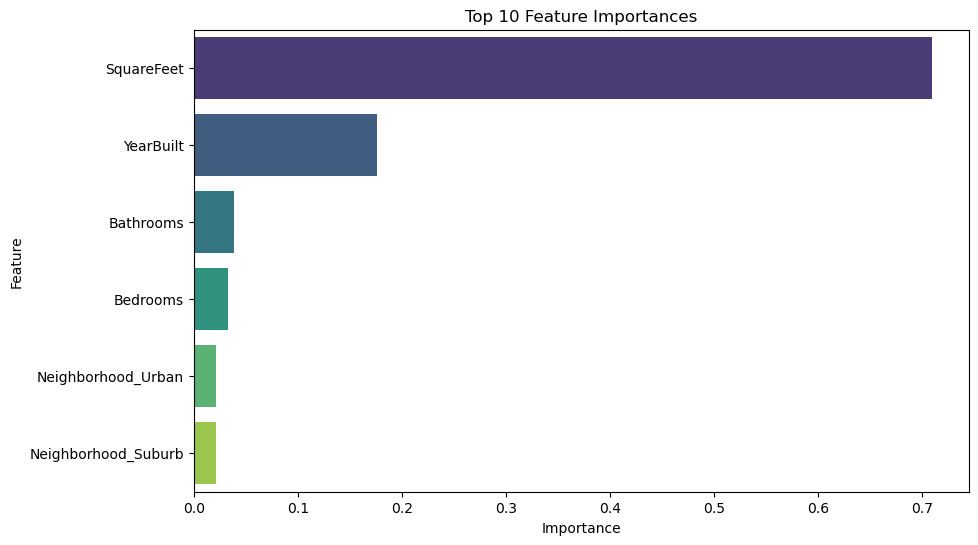

In [10]:
# Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances')
plt.show()

### Next Steps

- Improve Model Accuracy: Consider experimenting with more sophisticated algorithms (e.g., Gradient Boosting, XGBoost) and hyperparameter tuning to improve the performance.

- Feature Engineering: Investigate additional features like home age, condition, or local amenities that could improve the model’s accuracy.

- Outlier Detection: Explore the large errors in the model and see if better handling of outliers could lead to more accurate predictions.